In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [2]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "CQA"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [4]:
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("CQA", 1, "bar")


        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bars= self.GenerateBarData(width, height)
            self.add_image("CQA", image_id=i, path=None,
                           width=width, height=height, bars=bars)#,
                          # bg_color=bg_color, shapes=shapes)
                
    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        bars = info['bars']
        image = np.ones(shape=(info['height'], info['width'], 3))
        image= self.drawImage(image, bars, info['height'],  info['width'])
        return image
    
    
    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        bars = info['bars']
        count = len(bars)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (bar_name, _, dims) in enumerate(info['bars']):
 
            mask[:, :, i:i+1] = self.drawImage(mask[:, :, i:i+1].copy(),
                                                [bars[i]], info['height'], info['width'], True)

        
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index('bar') for s in bars])
        return mask.astype(bool), class_ids.astype(np.int32)
        
    
    def GenerateBarData(self, height, width):
    
        min_num_obj = 3
        max_num_obj = 6
        num=np.random.randint(min_num_obj, max_num_obj + 1)
        #todo: change max_obj_num for more bars
        max_obj_num = 6
        colors = np.random.uniform(0.0, 0.9,size = (max_obj_num,3))
        heights = np.random.randint(10,80,size=(num))

        barWidth = int( (width-3*(num+1)-3)//num * (np.random.randint(50,100)/100.0) )
        barWidth = max(barWidth, 4)
        spaceWidth = (width-(barWidth)*num)//(num+1)

        sx = (width - barWidth*num - spaceWidth*(num-1))//2
        bars = []

        for i in range(num):

            sy = width - 1
            ex = sx + barWidth
            ey = sy - heights[i]

            bar_name = 'bar_{}'.format(i)
            bars.append((bar_name, colors[i], (sx, sy, ex, ey)))
            sx = ex + spaceWidth

        return bars
     
    
    def drawImage(self, image, bars, height, width, mask=False):
        
        for bar in bars:
            sx, sy, ex, ey = bar[2]
            if mask== False:
                color = bar[1]
            else:
                color = 1
            cv2.rectangle(image,(sx,sy),(ex,ey),color,-1)
        if mask is False:
            channel  = 3
            noises = np.random.uniform(0, 0.05, (height, width,channel))
            image = image + noises
            _min = 0.0
            _max = image.max()
            image -= _min
            image /= (_max - _min)
        
        return image * 255
        

In [5]:
dataset_train = ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

dataset_val = ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

In [6]:
mask, _= dataset_train.load_mask(3)
mask.shape

(128, 128, 6)

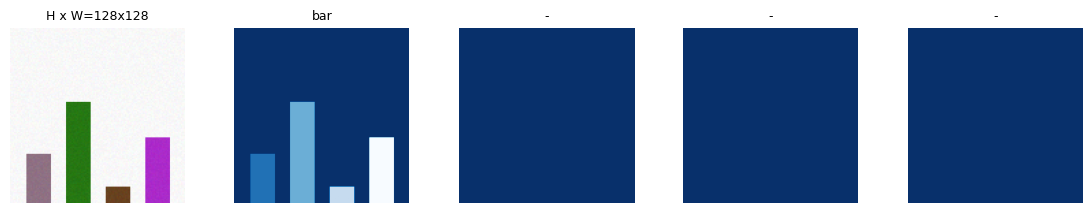

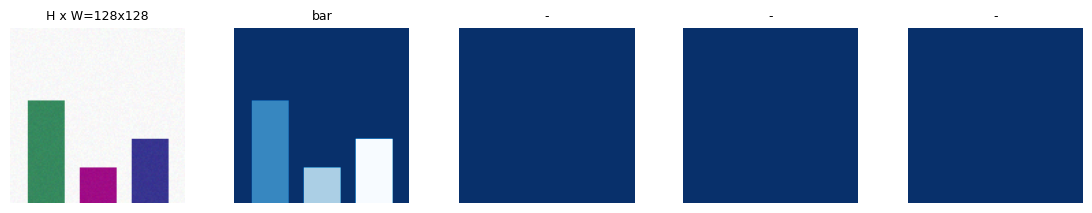

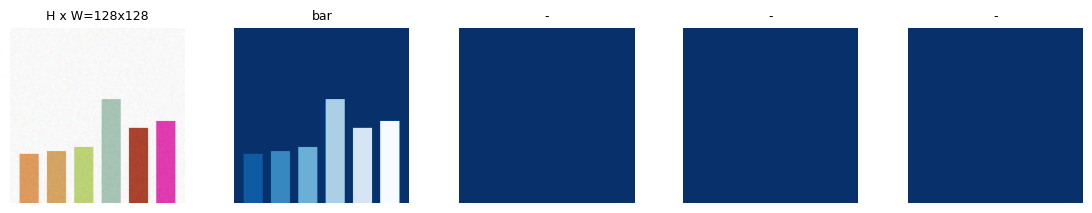

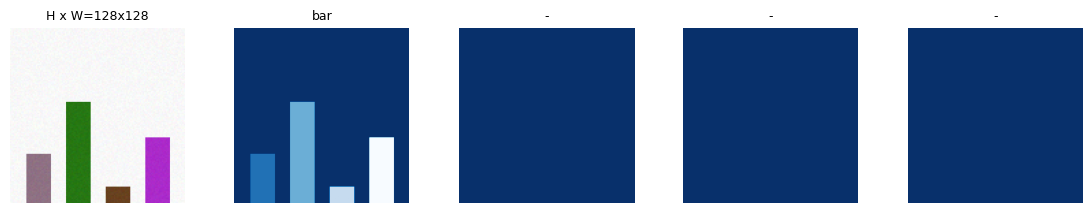

In [7]:
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [8]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [9]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

2023-03-10 15:12:54.184096: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2023-03-10 15:12:54.209620: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3000000000 Hz
2023-03-10 15:12:54.212438: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x112b0b90 executing computations on platform Host. Devices:
2023-03-10 15:12:54.212494: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version


In [10]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/mahsa.geshvadi001/projects/TF2MaskRCNN/Mask-RCNN-TF2/logs/cqa20230310T1512/mask_rcnn_cqa_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4    

ValueError: Error when checking input: expected input_gt_masks to have shape (56, 56, None) but got array with shape (128, 128, 100)

In [ ]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

In [ ]:
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
model.keras_model.save_weights(model_path)

In [ ]:
import os
os.makedirs('./logdir/train')

In [ ]:
dataset_train.image_info

In [79]:
mask, s= dataset_train.load_mask(7)

In [88]:
mask = mask[:, :, 1:2]
mask = mask.astype(np.uint8)  #convert to an unsigned byte
mask*=255

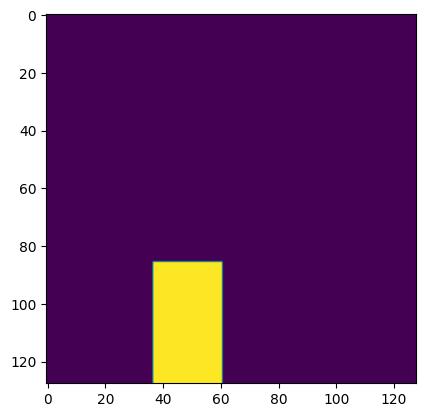

In [89]:
plt.imshow(mask)

In [18]:
mask = np.zeros([128, 128 , 6], dtype=np.uint8)
mask = dataset_train.drawImage(mask[:, :, 2:2+1].copy(), [('bar_1', ([0.2282136 , 0.6743791 , 0.83818975]), (53, 127, 75, 68))]
               , 128, 128, True)

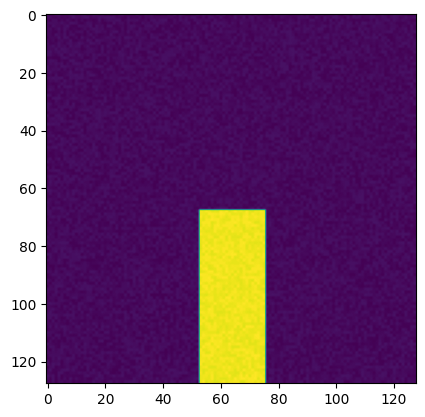

In [19]:
plt.imshow(mask)

In [24]:
dataset_train.image_info

[{'id': 0,
  'source': 'CQA',
  'path': None,
  'width': 128,
  'height': 128,
  'bars': [('bar_0',
    array([0.61735443, 0.32815749, 0.20469804]),
    (15, 127, 29, 64)),
   ('bar_1', array([0.75227374, 0.04036885, 0.65317508]), (43, 127, 57, 54)),
   ('bar_2', array([0.18109834, 0.33323663, 0.30501417]), (71, 127, 85, 52)),
   ('bar_3',
    array([0.79629571, 0.75003543, 0.53853979]),
    (99, 127, 113, 79))]},
 {'id': 1,
  'source': 'CQA',
  'path': None,
  'width': 128,
  'height': 128,
  'bars': [('bar_0',
    array([0.01768266, 0.86968568, 0.42511092]),
    (12, 127, 29, 95)),
   ('bar_1', array([0.3881898 , 0.7517346 , 0.85406058]), (41, 127, 58, 107)),
   ('bar_2', array([0.2271804 , 0.49903176, 0.76824859]), (70, 127, 87, 113)),
   ('bar_3',
    array([0.14472736, 0.48772927, 0.43648491]),
    (99, 127, 116, 88))]},
 {'id': 2,
  'source': 'CQA',
  'path': None,
  'width': 128,
  'height': 128,
  'bars': [('bar_0',
    array([0.79330664, 0.37217698, 0.49224799]),
    (8, 127, 

In [52]:
image =dataset_train.load_image(56)
image = image*255

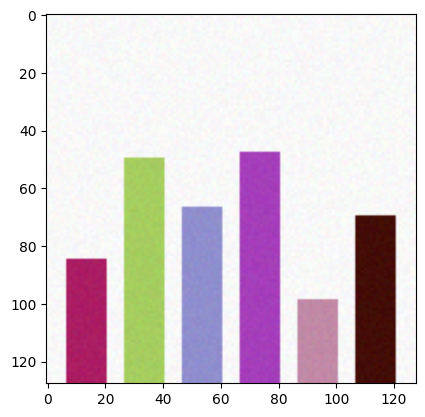

In [53]:
plt.imshow(image.astype(np.uint8), cmap=None,
                   norm=None, interpolation=None)
plt.show()

In [9]:
image, _, featureVector = gen.GenerateOneBarChart(128, 128)

ValueError: too many values to unpack (expected 3)

In [10]:
import matplotlib.pyplot as plt

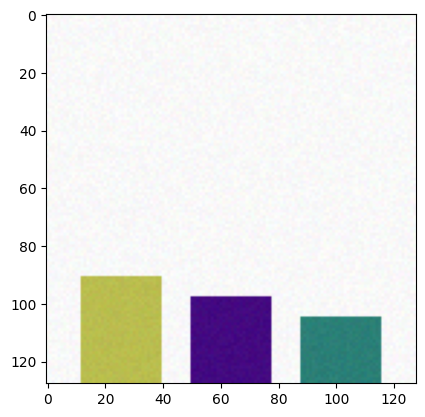

In [11]:
plt.imshow(image)

In [12]:
import cv2

In [13]:
cv2.imwrite('./imagetest.png', image * 255)


True

In [8]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Loading weights from  /home/mahsa.geshvadi001/projects/TF2MaskRCNN/Mask-RCNN-TF2/logs/cqa20230309T1548/mask_rcnn_cqa_0001.h5


2023-03-09 17:11:37.638171: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2023-03-09 17:11:37.661614: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3000000000 Hz
2023-03-09 17:11:37.663148: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1121dbb0 executing computations on platform Host. Devices:
2023-03-09 17:11:37.663168: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version


Re-starting from epoch 1


original_image           shape: (128, 128, 3)         min:   18.33644  max:  255.00000  float64
image_meta               shape: (14,)                 min:    0.00000  max:  128.00000  int64
gt_class_id              shape: (4,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (4, 4)                min:   14.00000  max:  128.00000  int32
gt_mask                  shape: (128, 128, 4)         min:    0.00000  max:    1.00000  bool


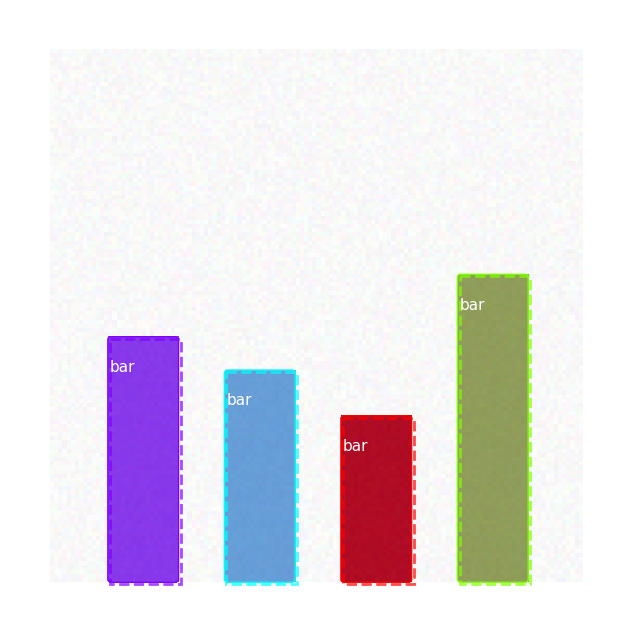

In [12]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id)#, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:   18.33644  max:  255.00000  float64
molded_images            shape: (1, 128, 128, 3)      min:  -98.46356  max:  151.09939  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


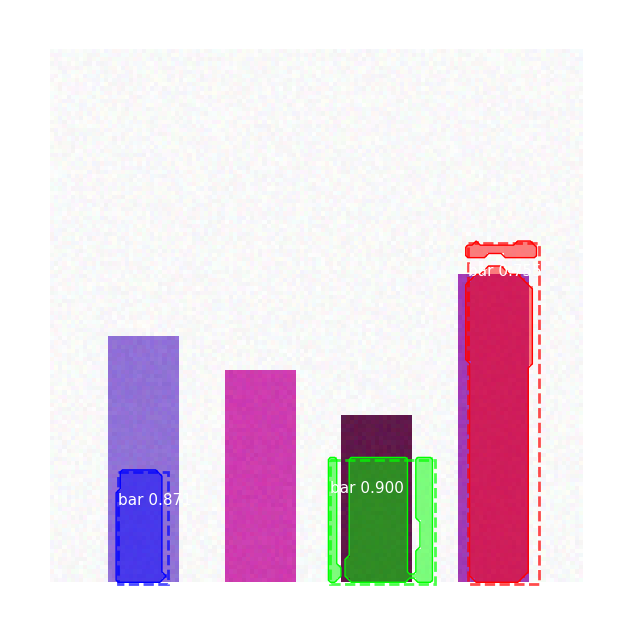

In [15]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())